In [1]:
import pandas as pd
import numpy as np

path = "../data/house_prices/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [2]:
from utils.models import CatBoostCV, LGBMCV
from utils.eda import reduce_mem_usage, missing_data, get_cats_nums

In [3]:
train.columns = [f.lower() for f in train.columns]
test.columns = [f.lower() for f in test.columns]

In [4]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

In [6]:
missing_data(train)

,Total,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
...,...,...
centralair,0,0.000000
salecondition,0,0.000000
heating,0,0.000000
totalbsmtsf,0,0.000000


In [7]:
missing_data(test)

,Total,Percent
poolqc,1456,99.794380
miscfeature,1408,96.504455
alley,1352,92.666210
fence,1169,80.123372
fireplacequ,730,50.034270
...,...,...
electrical,0,0.000000
centralair,0,0.000000
heatingqc,0,0.000000
foundation,0,0.000000


# Drop columns that 90% is missing

In [8]:
miss = missing_data(train)

In [9]:
drop_cols = miss.loc[miss['Percent'] > 90.].index.tolist()

In [10]:
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [11]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,3ssnporch,screenporch,poolarea,fence,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


# Let's just impute right away for the sake of demo.

In [12]:
unused_cols = ['id', 'saleprice']

In [13]:
cats, nums = get_cats_nums(train)

In [14]:
cats

['mszoning',
 'street',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 'kitchenqual',
 'functional',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'paveddrive',
 'fence',
 'saletype',
 'salecondition']

In [15]:
nums = [f for f in nums if f not in unused_cols]

In [16]:
import gc; gc.enable()
for cat in cats:
    impute_value = train[cat].mode()[0]
    train[cat] = train[cat].fillna(impute_value)
    test[cat] = test[cat].fillna(impute_value)
    del impute_value; gc.collect()

In [17]:
for num in nums:
    impute_value = train[num].mean()
    train[num] = train[num].fillna(impute_value)
    test[num] = test[num].fillna(impute_value)

In [18]:
feats = cats + nums

In [19]:
feats

['mszoning',
 'street',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 'kitchenqual',
 'functional',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'paveddrive',
 'fence',
 'saletype',
 'salecondition',
 'mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'woo

In [20]:
train['saleprice'].min(), train['saleprice'].max()

(34900, 755000)

In [21]:
#transform the target to log
train['saleprice'] = np.log(train['saleprice'])

In [22]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of properties dataframe is : 0.86895751953125  MB
******************************
Column:  id
dtype before:  int64
min for this col:  1
max for this col:  1460
dtype after:  uint16
******************************
******************************
Column:  mssubclass
dtype before:  int64
min for this col:  20
max for this col:  190
dtype after:  uint8
******************************
******************************
Column:  lotfrontage
dtype before:  float64
min for this col:  21.0
max for this col:  313.0
dtype after:  float32
******************************
******************************
Column:  lotarea
dtype before:  int64
min for this col:  1300
max for this col:  215245
dtype after:  uint32
******************************
******************************
Column:  overallqual
dtype before:  int64
min for this col:  1
max for this col:  10
dtype after:  uint8
******************************
******************************
Column:  overallcond
dtype before:  int64
min for this col:  1

In [23]:
### MODEL
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
params = {
    'eval_metric':'RMSE',
    'loss_function': 'RMSE',
  #  'task_type': 'GPU', #if you want to train on GPU
    'iterations': 5000,
    'learning_rate': 0.03,
    'early_stopping_rounds':50,
    'cat_features': cats,
    'one_hot_max_size': 3,# helpful in high cardinality features
    'bootstrap_type': 'Bayesian', #Bayesian is the default
    'depth': 7, #depth is useful if range 4~12
 #   'l2_leaf_reg': 0.3,  #reg_lambda is the alias of l2_leaf_reg
  #  'random_strength': 1,  #works like gamma in XGBOOST
   # 'subsample': 0.8 #works like feature_fraction in lightgbm if bootstrap_type = Bernoulli
}

In [24]:
kf = KFold(n_splits=3, shuffle=True, random_state=13)

In [25]:
kf_splitted = kf.split(train[feats])
train[cats] = train[cats].astype('category')

In [26]:
#FeaturesData assumes that your numerical values are in float
train[nums] = train[nums].astype(np.float32)
test[nums] = test[nums].astype(np.float32)

In [27]:
cb_model = CatBoostCV(
    cv=kf_splitted,
    obj='regression',
    cats=cats,
    nums=nums,
     random_state=21,
     **params
    )

In [28]:
cb_model = cb_model.fit(
    train, train.saleprice,
    verbose_eval=1000,
    use_best_model=True
)

0:	learn: 11.6905306	test: 11.7276660	best: 11.7276660 (0)	total: 103ms	remaining: 8m 32s
1000:	learn: 0.1473867	test: 0.2094320	best: 0.2094320 (1000)	total: 24.9s	remaining: 1m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2055849914
bestIteration = 1620

Shrink model to first 1621 iterations.
0:	learn: 11.6877465	test: 11.6594829	best: 11.6594829 (0)	total: 20.4ms	remaining: 1m 41s
1000:	learn: 0.1543174	test: 0.1903782	best: 0.1903782 (1000)	total: 26.1s	remaining: 1m 44s
2000:	learn: 0.1355583	test: 0.1852333	best: 0.1852198 (1997)	total: 1m	remaining: 1m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1852197926
bestIteration = 1997

Shrink model to first 1998 iterations.
0:	learn: 11.6863981	test: 11.6841825	best: 11.6841825 (0)	total: 11.7ms	remaining: 58.4s
1000:	learn: 0.1606118	test: 0.2228153	best: 0.2227822 (995)	total: 26.4s	remaining: 1m 45s
2000:	learn: 0.1442585	test: 0.2137620	best: 0.2136906 (1982)	total: 1m	remaining

In [29]:
np.mean(cb_model.model_scores_)

0.20149633155549077

In [30]:
cb_model.feature_importances_.sort_values('importance_0', ascending=False)

,feature_names,importance_0,importance_1,importance_2
71,garagecond,8.508436,1.288384,0.655828
65,kitchenqual,7.317957,0.927858,6.973435
63,centralair,6.378936,1.042815,0.544548
22,totrmsabvgrd,5.278536,0.820975,1.660363
49,roofmatl,4.811167,0.022558,0.060944
...,...,...,...,...
30,3ssnporch,0.004006,0.042957,0.007151
66,functional,0.003777,0.009743,0.001285
21,kitchenabvgr,0.000514,1.673055,2.893236
43,neighborhood,0.000000,0.000000,0.000000


In [31]:
cb_model.model_scores_

[0.2055849914443509, 0.185219792638457, 0.21368421058366438]

In [32]:
pd.read_csv(path+"sample_submission.csv")

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [33]:
test[cats] = test[cats].astype('category')

In [34]:
from catboost import Pool, FeaturesData

test_set = Pool(
    data=FeaturesData(
        num_feature_data=test[nums].values,
        cat_feature_data=test[cats].values,
        num_feature_names=nums,
        cat_feature_names=cats
    )
)

In [35]:
test['SalePrice'] = cb_model.predict(test_set)

In [36]:
test['SalePrice'].sample(10)

353     11.549533
703     12.386232
583     12.124030
934     12.101680
742     11.902774
664     11.982462
295     11.582018
521     12.219193
1420    11.728201
1404    11.853150
Name: SalePrice, dtype: float64

In [37]:
test['SalePrice'] = np.exp(test['SalePrice']) #back to its original state

In [38]:
test['SalePrice'].sample(10)

718     133153.713324
1345     97268.873507
1078    178960.342363
578     173647.142606
1041    137457.192279
404     338310.459064
549     210281.231226
293     201083.487441
954     157817.883639
136     188935.207861
Name: SalePrice, dtype: float64

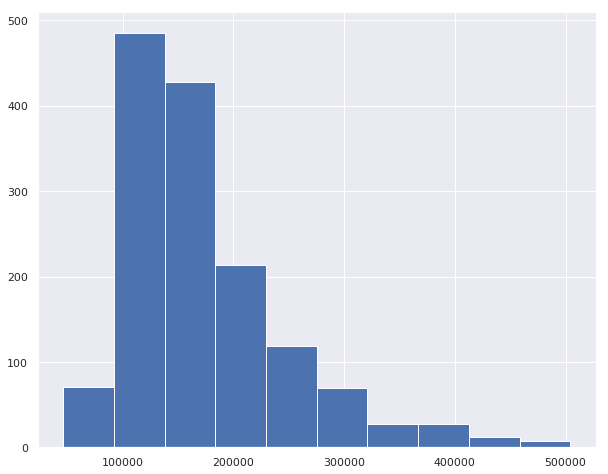

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
plt.figure(figsize=(10,8))
test['SalePrice'].hist();

In [40]:
test.rename(columns={'id': 'Id'}, inplace=True)

In [41]:
submission_path = "submission/house_prices_submission/"

In [42]:
test[['Id', 'SalePrice']].to_csv(submission_path+"catboost_house_prices_basic.csv", index=False)